<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 9th exercise: <font color="#C70039">Interpretable Machine Learning by means of Partial Dependence (PDP) and Individual Conditional Expectation (ICE) Plots</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Finn Heydemann
* Date:   03.12.2023

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_partial_dependence_003.png" style="float: center;" width="800">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze the interaction between the target response and a set of input features of interest.
Both PDPs [H2009] and ICEs [G2015] assume that the input features of interest are independent from the complement features and this assumption is often violated in practice. Thus, in the case of correlated features, we will create absurd data points to compute the PDP/ICE.

[H2009]
T. Hastie, R. Tibshirani and J. Friedman, The Elements of Statistical Learning, Second Edition, Section 10.13.2, Springer, 2009.

[G2015]
A. Goldstein, A. Kapelner, J. Bleich, and E. Pitkin, “Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation” Journal of Computational and Graphical Statistics, 24(1): 44-65, Springer, 2015.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * try to follow the interpretations by printing out the decision tree and look for the feature patterns that the PDPs indicate.

**PART I**<br>
4. download an interesting data set from Kaggle and do the preprocessing.<br>
5. change the classifier according to the data set. The more blackbox the better.<br>
6. use PDP to identify the most relevant features explaining the target response of the data set.<br> 
7. comment your entire code and your findings.<br>  

**PART II**<br>
8. use the data set and the classifer from steps 4 and 5<br>
9. plot ICE curves with parameter (kind='both')<br>
10. comment your entire code and your findings.<br>  

---------------------------------

# <font color="ce33ff">PART I (Partial Dependence Plots)</font>

## Imports
Import all necessary python utilities.

In [1]:
#make sure you take these packages (in colab too)
#!pip install matplotlib==3.1.1 scikit-learn==0.23.1 PDPbox==0.2.1

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from pdpbox import pdp, info_plots

#import warnings 
#warnings.filterwarnings('ignore')

## Load data set

In [3]:
data = pd.read_csv('./data/FIFA/FIFA.Statistics.2018.csv')
data.head(3)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [4]:
# all features are:
data.columns

Index(['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %',
       'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

## Preprocessing


In [5]:
# Convert from string “Yes”/”No” to binary
y = (data['Man of the Match'] == 'Yes') 

feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]

x = data[feature_names]

## Train the classifier

Start with a simple decision tree model.
<font color=red>Note:</font> The calculation of a partial dependence can happen obviously, only after a model has been trained. 

In [6]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)
train_x

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
88,0,54,10,3,4,3,5,1,8,2,86,557,83,11,1,0,0,0
74,0,53,14,2,7,5,8,3,13,1,86,555,105,13,4,0,0,0
120,1,40,19,5,8,6,4,1,17,3,86,342,102,6,2,0,0,0
45,3,42,15,5,6,4,2,3,18,3,80,372,104,23,4,0,0,0
77,2,66,8,4,3,1,5,2,20,2,84,565,101,15,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,1,49,4,1,2,1,1,0,16,4,85,390,111,19,3,0,0,0
72,0,38,5,1,2,2,4,1,11,4,72,305,106,10,1,0,0,0
12,0,52,18,6,7,5,3,5,21,2,85,394,104,10,1,0,0,0
107,2,44,11,4,4,3,6,1,14,5,83,453,109,9,1,0,0,0


## Partial Dependence Plots (PDP)
#### read the API reference guide for further possibilities 
https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html#pdpbox.pdp.PDPIsolate

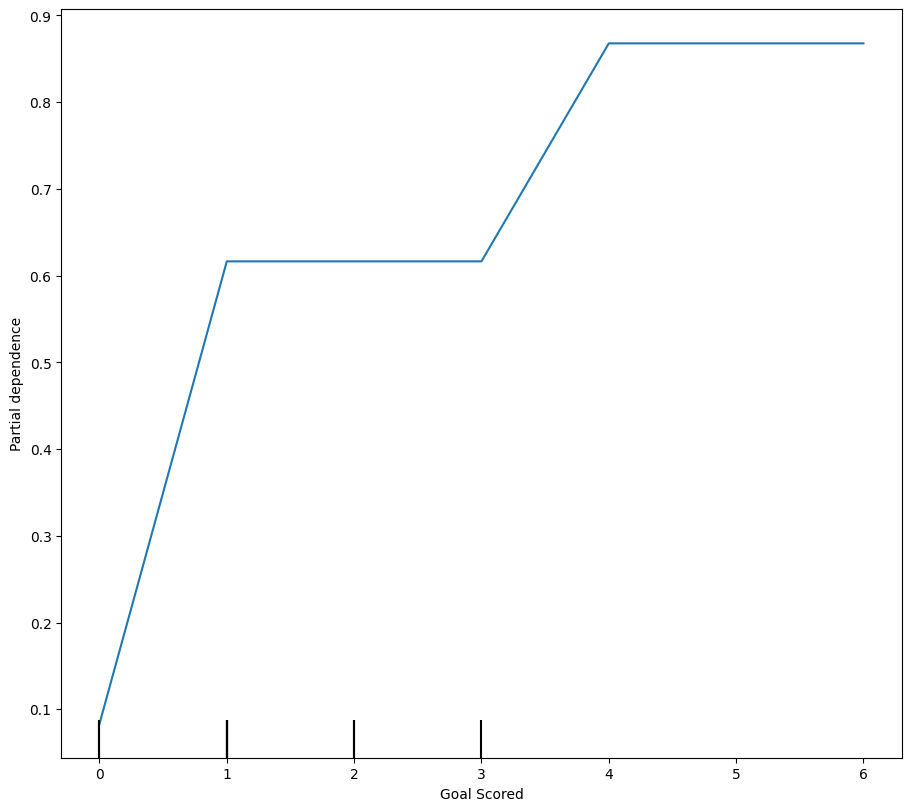

In [7]:
# Create the pdp data to be plotted
from sklearn.inspection import PartialDependenceDisplay

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    tree_model,
    train_x,
    features = ["Goal Scored"],
    ax=ax,
)

A few things are worth to be pointed out for interpreting this plot.

The y-axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

From this particular graph you can interpret, that scoring one goal substantially increases the chances of winning "Man of The Match." 
But extra goals beyond that show little to no impact on predictions.

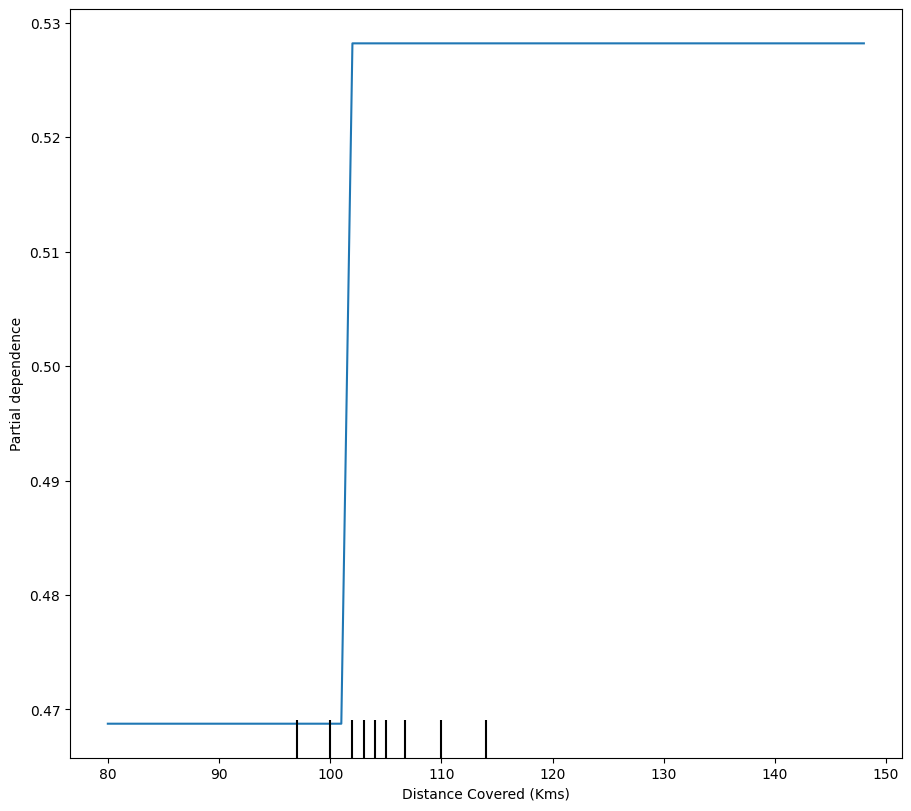

In [8]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    tree_model,
    train_x,
    features = ["Distance Covered (Kms)"],
    ax=ax,
)

In this PDP plot you will see the ticks on the x-axis as depicting the real data samples.

This PDP plot seems to be too simple to represent reality. 
Maybe that's because the model is so simple. Print the decision tree to compare that finding to the decision tree structure.
For the purpose of 
Let's back up our theory and do the same plot with a Random Forest model.

In [9]:
# Build a new model: Random Forest classifier
rf_model = RandomForestClassifier(random_state=0).fit(train_x, train_y)

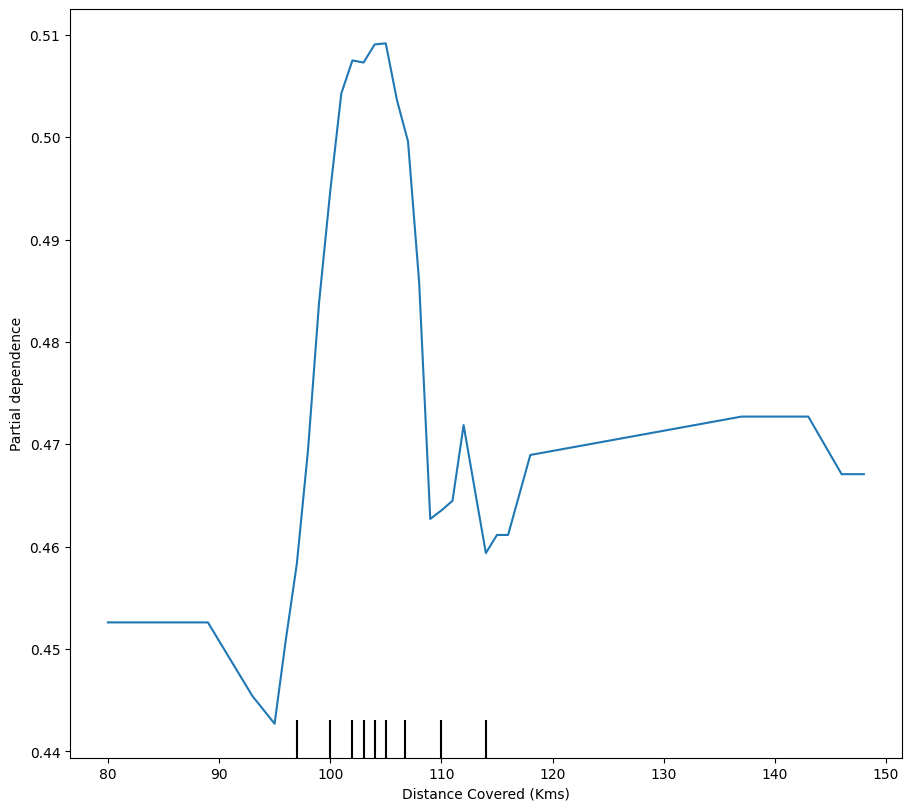

In [10]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    train_x,
    features = ["Distance Covered (Kms)"],
    ax=ax,
)

<font color=red>Interpretation:</font> 
This model states that it is more likely to win "Man of the Match" if the players run a total of about 100 km during the match. More running leads to lower predictions.
In general, the smoother shape of this curve seems more plausible than the step function of the decision tree model. 
However, this data set is much too small. One should be very careful when interpreting a model.

## 2D Partial Depedence Plot

Now, plotting the PDP for two features can be done by using the **pdp_interact** and **pdp_interact_plot** functions.

First, switch back to the simple decision tree model.

In [11]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

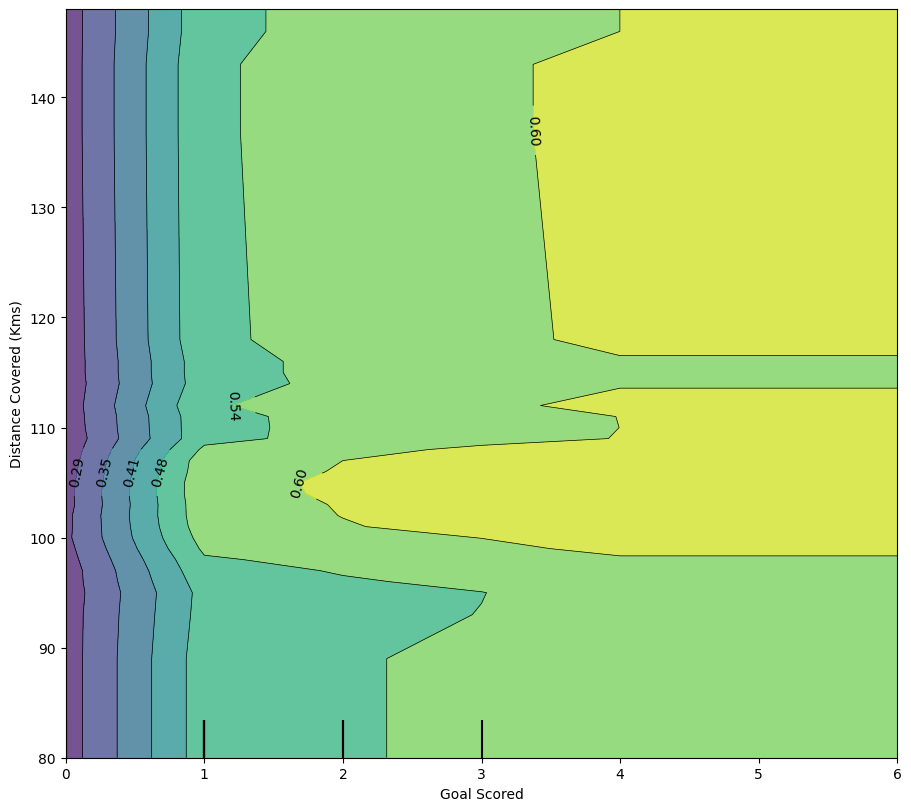

In [12]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    train_x,
    features = [("Goal Scored", "Distance Covered (Kms)")],
    ax=ax,
)

<font color=red>Interpretation:</font> 
This **2D PDP** shows predictions for any combination of **Goals Scored** and **Distance Covered (Kms)**.

For example, it seems to yield the highest predictions when a team scores at least one (1) goal and they run a total distance close to 100km. 
If the players score 0 goals, the covered distance does not matter. 

Try to see this by tracing through the decision tree with 0 goals!

But distance can impact predictions if the players score goals. 
Make sure you can see this from the 2D PDP. 
Can you find this pattern in the decision tree too?

If you feel motivated to tweak the chart this tutorial ressource might be of value: 
https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_binary_classification.ipynb

If the players score one or more goals the ran distance does inpact the outcome. If the team runs more than 101 km the likelihood of receiving the man of the match award trophy rises from 0,61 to 0,73  

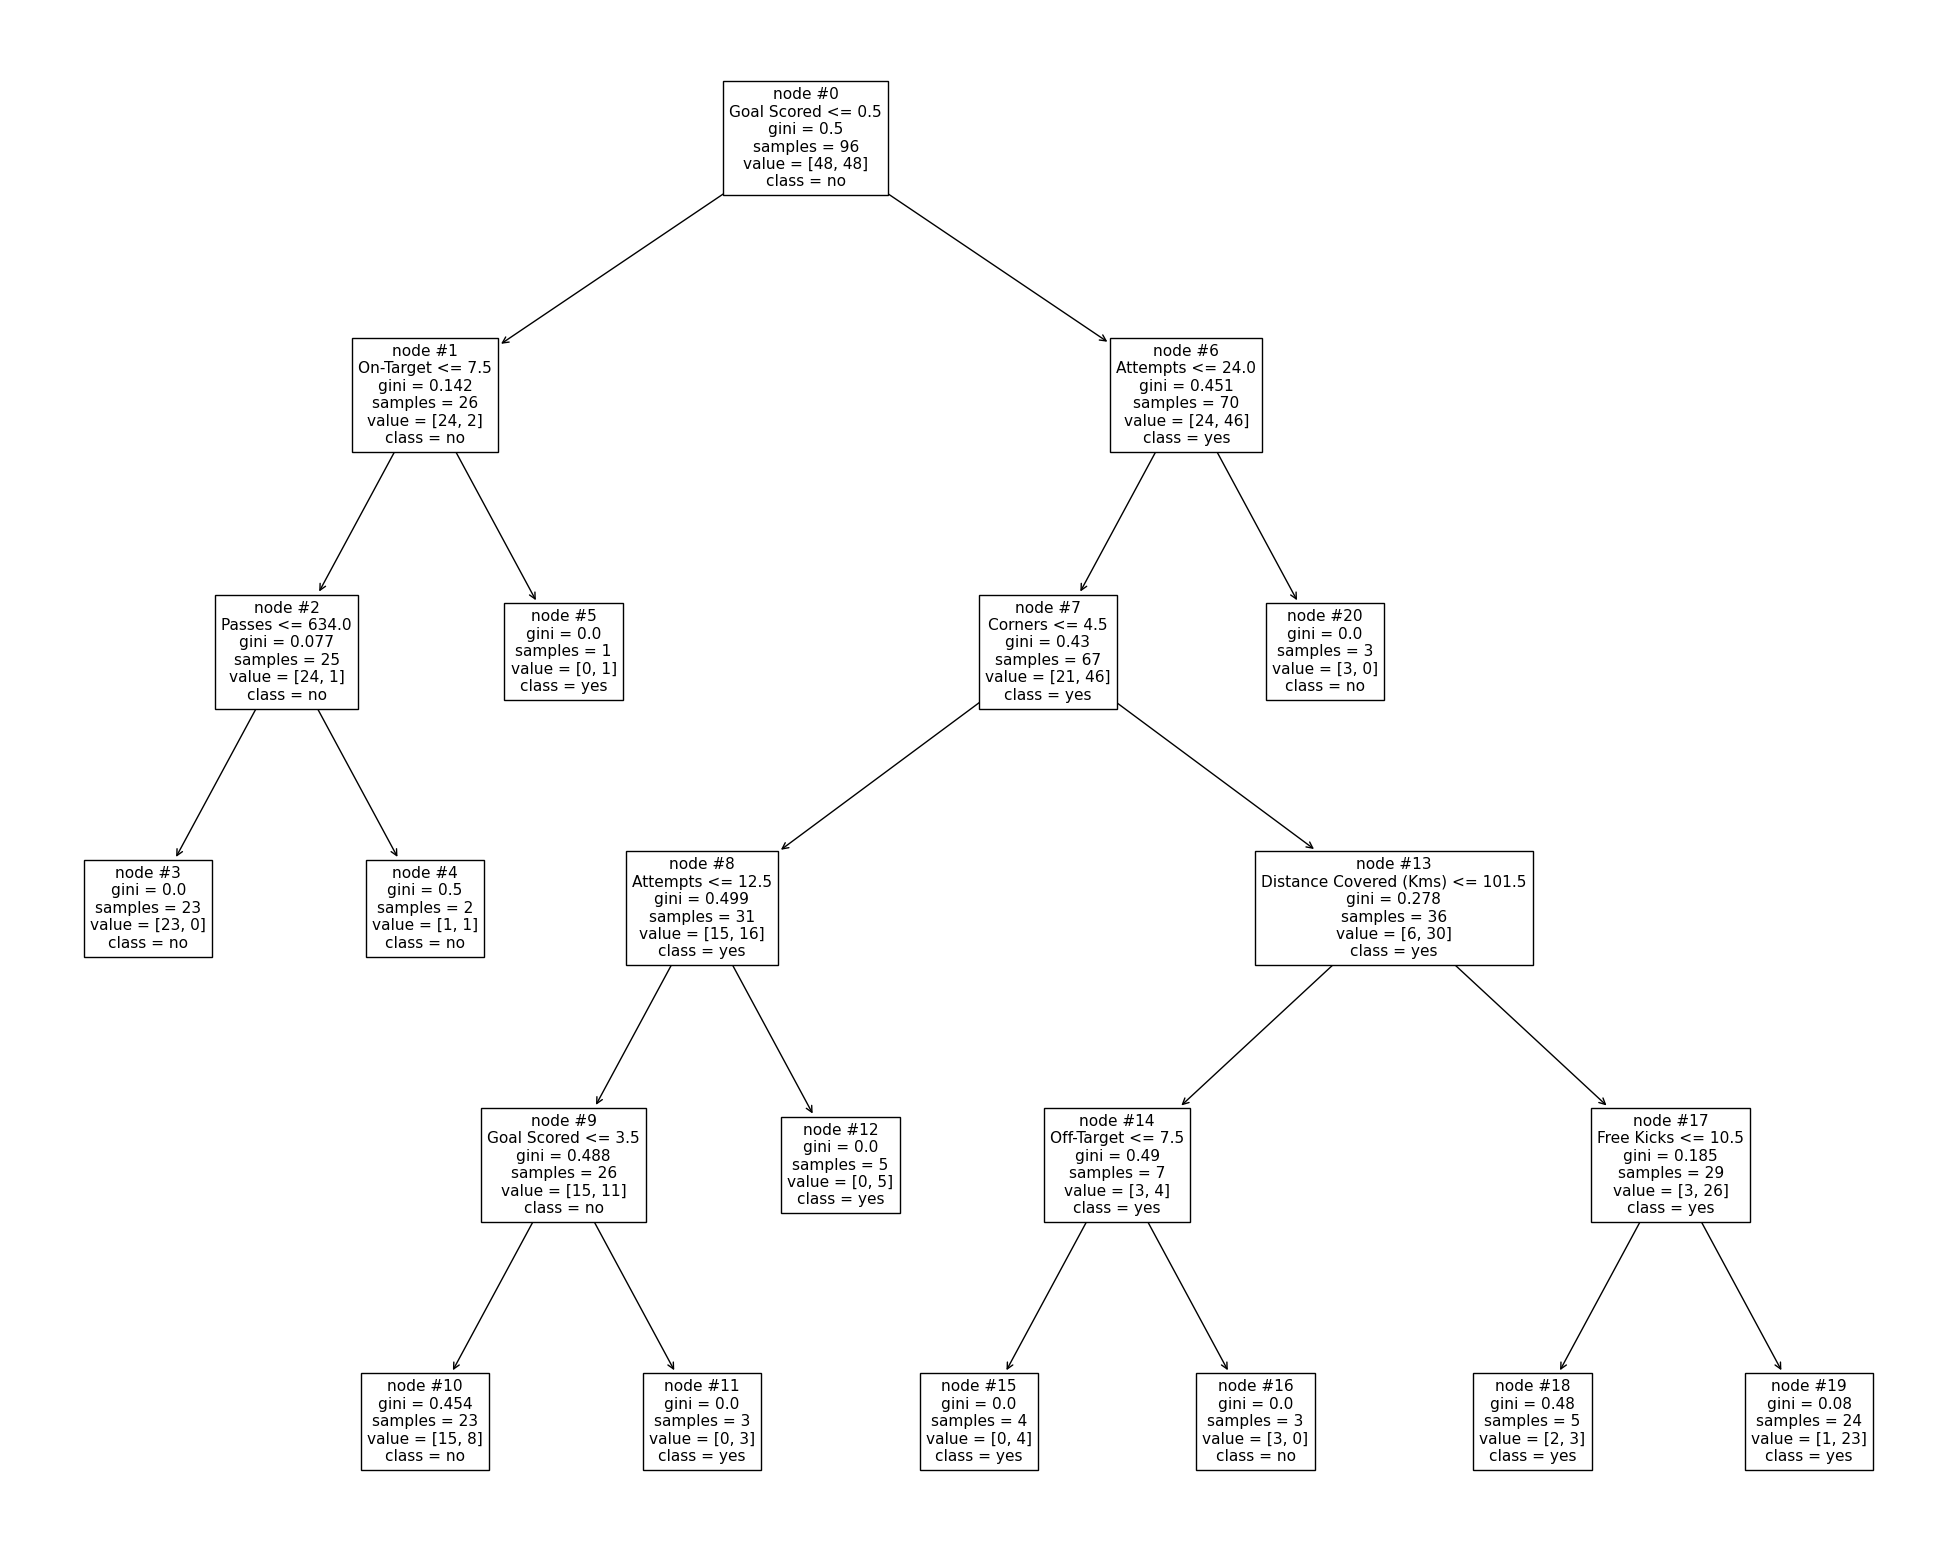

In [13]:
from sklearn import tree 

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_model, 
               feature_names=feature_names,
               node_ids=True, 
              class_names=["no", "yes"])
plt.show()

In [14]:
samples = train_x.iloc[55:56]
print(samples)
decision_paths = tree_model.decision_path(samples)
for path in decision_paths.toarray(): 
    print(f"Passes through nodes: {np.where(path)[0]}")
tree_model.predict(samples)

   Goal Scored  Ball Possession %  Attempts  On-Target  Off-Target  Blocked  \
0            5                 40        13          7           3        3   

   Corners  Offsides  Free Kicks  Saves  Pass Accuracy %  Passes  \
0        6         3          11      0               78     306   

   Distance Covered (Kms)  Fouls Committed  Yellow Card  Yellow & Red  Red  \
0                     118               22            0             0    0   

   Goals in PSO  
0             0  
Passes through nodes: [ 0  6  7 13 17 19]


array([ True])

As can be seen in the tree plot when a team scores less than "0,5" (1) goal (left part of the tree), the distance covered plays no role at all. If a team scores more than "0,5" (1) goal (right part of the tree), higher distances covered will lead to positive predictions in some cases. 

# <font color="ce33ff">PART II (Individual Conditional Expectation)</font>

ICE is also a model-agnostic method that can be applied to any model. 
In fact, it is basically the same concept as PDP but is different in that it displays the marginal effect of feature(s) 
for each instance instead of calculating the average effect in a overall data context as the PDP does. 
Thus, it can understood as the equivalent to a PDP for individual data instances. 
Visually, an ICE plot displays the dependence of the prediction on a feature for each instance separately, 
resulting in one line per instance.

There are multiple packages and libraries that can be used to compute ICE plots. 

The PartialDependenceDisplay function in the sklearn.inspection module, the PyCEBox package and H2O package’s ice_plot function are available.

Let’s take a look at an example in Sklearn’s documentation (https://scikit-learn.org/stable/modules/partial_dependence.html).

## Imports
Import all necessary python utilities.

In [15]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# make sure you have installed scikit-learn of version > 1.0 
# since the method from_estimator() is not available in previous versions
from sklearn.inspection import PartialDependenceDisplay

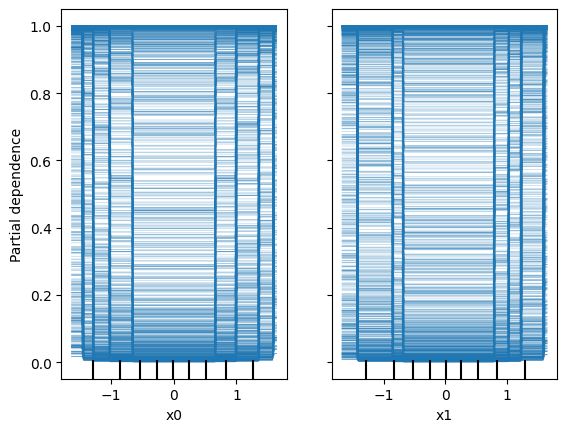

In [16]:
# Read some inbuild data set as part of the Sklearn data sets being offered
# To get more information on the data set please refer to 
''' https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html '''

x, y = make_hastie_10_2(random_state=0) # set a seed with random_state

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x, y)
features = [0, 1] #features x and y

PartialDependenceDisplay.from_estimator(clf, x, features, kind='individual')

It is evident that, similar to PDPs, ICE curves can be computed only after a model has been trained.

If you specify the parameter kind='both', then a PDP and an ICE curve is plotted in one canvas at the same time. 
This will be meaningful when looking at both, the marginal average effect and marginal individual effects at once!

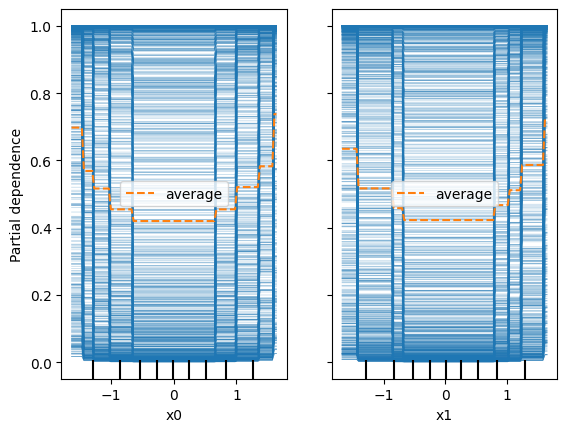

In [17]:
PartialDependenceDisplay.from_estimator(clf, x, features, kind='both')

In [20]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv("data/exercise_1/StudentsPerformance.csv")
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [21]:
data = data.to_numpy()
data = np.hstack((np.apply_along_axis(lambda x: np.unique(x, return_inverse=True)[1], 0, data[:, :5]), data[:, 5:])) # make everyting numeric

In [22]:
x, y = np.delete(data, 5, axis=1), data[:, 5] # predcit math score

x.shape, y.shape

((1000, 7), (1000,))

In [23]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)


In [24]:
from sklearn.tree import DecisionTreeRegressor

rfr = DecisionTreeRegressor()
rfr.fit(train_x, train_y)
pred = rfr.predict(val_x)
np.stack((pred, val_y), axis=1)[:10, :]

array([[55.0, 55],
       [53.0, 60],
       [59.0, 65],
       [50.0, 44],
       [50.0, 56],
       [40.0, 48],
       [47.0, 44],
       [46.0, 51],
       [68.0, 63],
       [86.0, 82]], dtype=object)

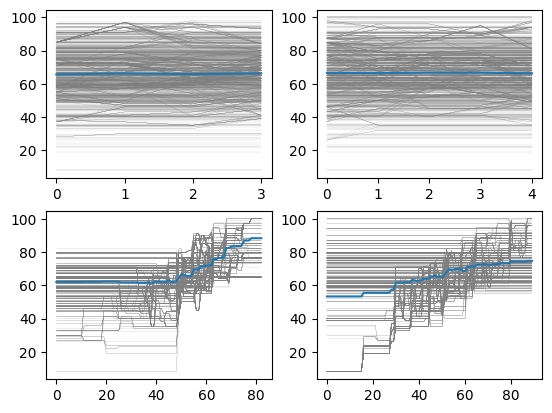

In [25]:
# make ice plot with pdp line, what impact do different features have? 

def make_pdp(model, data, index: int, stepsize: float = 1.0): 
    max_, min_ = data[:, index].max(), data[:, index].min()
    repeats = int((max_ - min_) // stepsize)
    data = np.delete(data, index, axis=1)
    a = np.tile(data, (repeats, 1))
    b = np.repeat(np.arange(min_, max_, stepsize), len(data)).reshape(-1, 1)
    test_data = np.insert(a, [index], b, axis=1)
    pred = model.predict(test_data)
    return pred.reshape(-1, 1000), np.mean(pred.reshape(-1, 1000), axis=1)
    

fig, axs = plt.subplots(2, 2)
for i, ax in zip((1, 2, 5, 6), axs.flatten()): 
    all_lines, average_line = make_pdp(rfr, x, i)
    ax.plot(all_lines, lw=.1, c="gray")
    ax.plot(average_line)
plt.show()

Every single data point is predicted with every possible race / parents education / writing and reading score. 
Interpretation: The parent education and the race don't seem to have a large input on the prediction because the average line is more or less constant. The reading and writing score though seems to have a large impact on the prediction --> higher scores here lead to higher math scores 

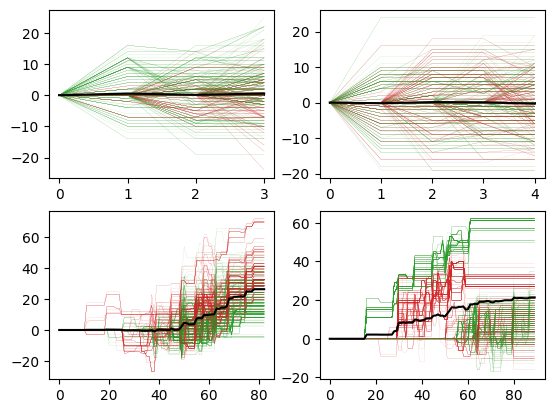

In [26]:
# Centered ice Plot

fig, axs = plt.subplots(2, 2)
for i, ax in zip((1, 2, 5, 6), axs.flatten()): 
    all_lines, average_line = make_pdp(rfr, x, i)
    for line, n_x in zip((all_lines - all_lines[0, :]).T, x): 
        ax.plot(line, lw=.05, c="tab:red" if n_x[0] else "tab:green")
    ax.plot(average_line - average_line[0], c="black")
plt.show()


Centered ICE Plot shows that reading and writing scores are important. Especially the writing score (bottom right) splits up into two branchens, one where better writing score don't affect the mathe score very mucht and one where higher writing scores yield better math scores. It looks as though this might be gender relevant (green and red) are more present in the upper or respecitly lower part. 

(1000, 3)
(1000, 4)
(1000, 82)
(1000, 89)


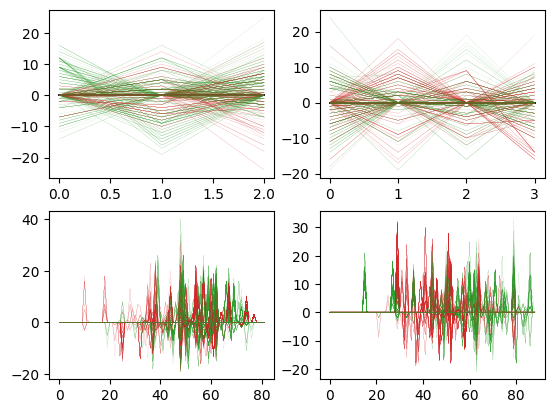

In [27]:
# d_ICE Plot 

fig, axs = plt.subplots(2, 2)
for i, ax in zip((1, 2, 5, 6), axs.flatten()): 
    all_lines, _ = make_pdp(rfr, x, i)
    print(np.diff((all_lines - all_lines[0, :]).T).shape)
    for line, n_x in zip(np.diff((all_lines - all_lines[0, :]).T), x): 
        ax.plot(line, lw=.05, c="tab:red" if n_x[0] else "tab:green")
plt.show()

Not much can be seen in these plot from my point of view

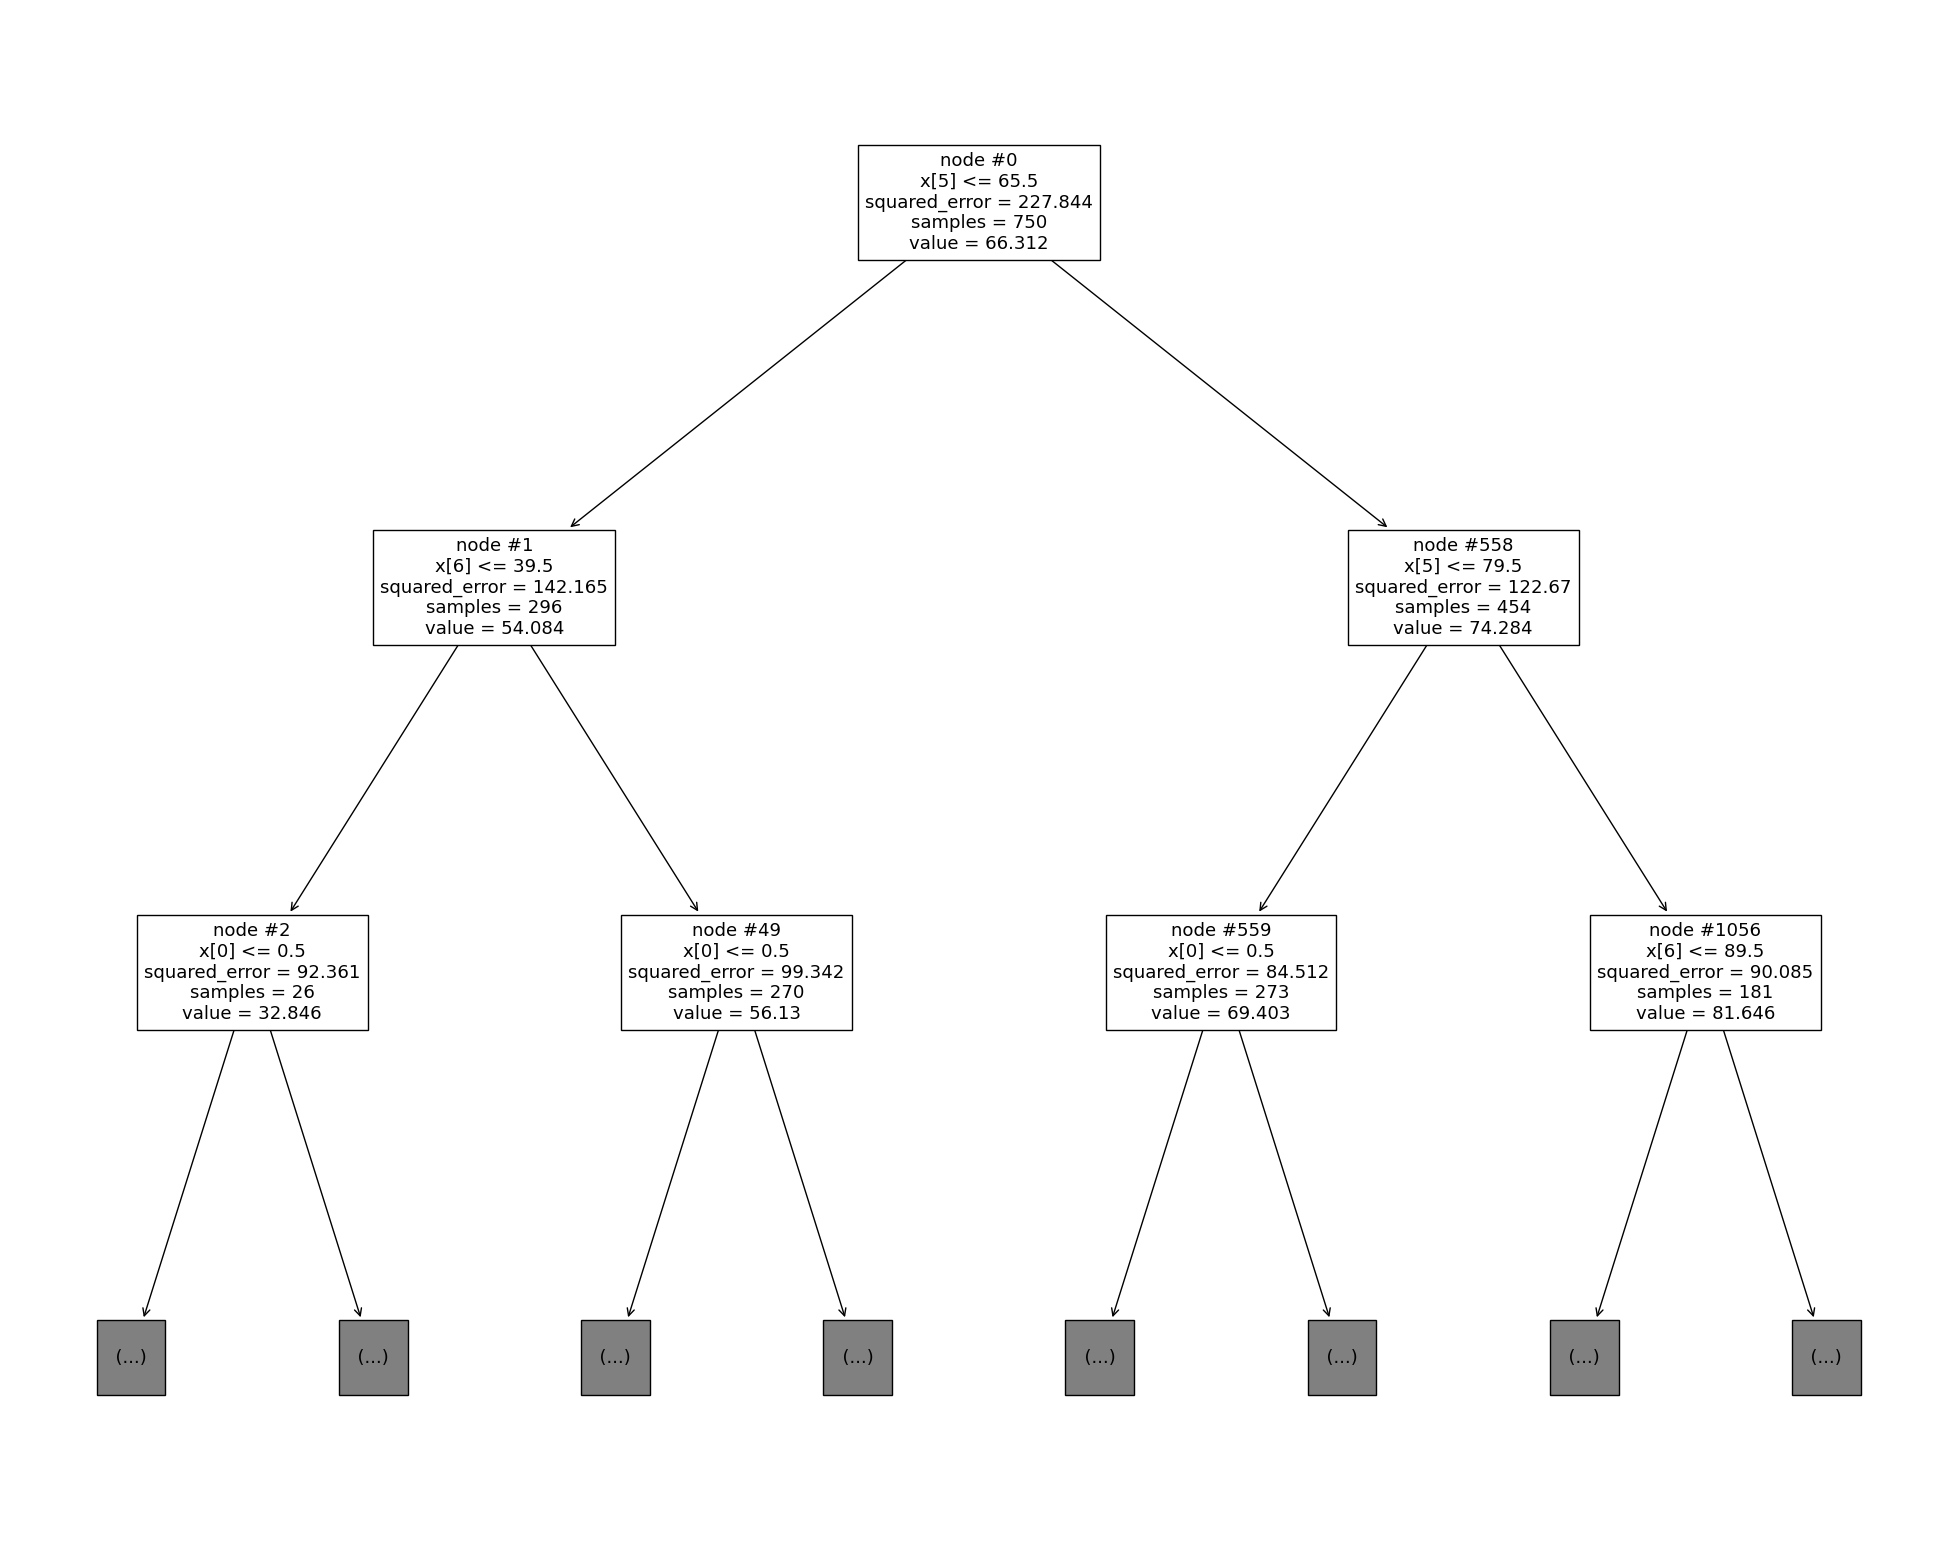

In [28]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rfr,
               node_ids=True, max_depth=2)
plt.show()